# Extract multi sensor data

In [13]:
%matplotlib inline

In [14]:
import pandas
pandas.set_option('display.max_colwidth', 200)
pandas.set_option('display.max_rows', 5) # limit of 5 rows to show

In [15]:
import numpy
import xarray
import datacube
from datacube_stats.statistics import GeoMedian
from datacube.helpers import ga_pq_fuser
from datacube.storage import masking
from datacube.helpers import write_geotiff
#from datacube.storage.masking import mask_invalid_data

In [16]:
dc = datacube.Datacube(app='multi-prod')

In [17]:
multi_sensor_query = {
    'time': ('2013-06-01', '2014-01-01'),
    'lat': (-41.7, -41.95),
    'lon': (147.6, 147.85),
}

products = ['ls7_nbart_albers', 'ls8_nbart_albers']

In [20]:
# Find similarly named measurements
measurements = set(dc.index.products.get_by_name(products[0]).measurements.keys())
for prod in products[1:]:
    measurements.intersection(dc.index.products.get_by_name(products[0]).measurements.keys())

print(measurements)

{'blue', 'swir2', 'green', 'nir', 'swir1', 'red'}


In [22]:
datasets = []
for prod in products:
    ds = dc.load(product=prod, measurements=measurements, **multi_sensor_query)
    ds['product'] = ('time', numpy.repeat(prod, ds.time.size))
    datasets.append(ds)
    
datasets

[<xarray.Dataset>
 Dimensions:  (time: 17, x: 979, y: 1181)
 Coordinates:
   * time     (time) datetime64[ns] 2013-06-13T23:47:57 ...
   * y        (y) float64 -4.64e+06 -4.64e+06 -4.64e+06 -4.64e+06 -4.64e+06 ...
   * x        (x) float64 1.324e+06 1.324e+06 1.324e+06 1.324e+06 1.324e+06 ...
 Data variables:
     blue     (time, y, x) int16 4518 4688 4920 5138 4994 4801 4832 5105 5290 ...
     swir2    (time, y, x) int16 2451 2546 2718 2819 2618 2631 2591 2534 3009 ...
     green    (time, y, x) int16 4357 4667 4926 4931 4911 4741 4726 4983 5185 ...
     nir      (time, y, x) int16 4440 4778 5006 5112 5034 4839 4875 5102 5379 ...
     swir1    (time, y, x) int16 2497 2602 2716 2758 2692 2593 2614 2634 2882 ...
     red      (time, y, x) int16 4426 4809 5020 5062 4915 4832 4869 4929 5361 ...
     product  (time) <U16 'ls7_nbart_albers' 'ls7_nbart_albers' ...
 Attributes:
     crs:      EPSG:3577, <xarray.Dataset>
 Dimensions:  (time: 12, x: 979, y: 1181)
 Coordinates:
   * time     (ti

In [25]:
combined = xarray.concat(datasets, dim='time')
combined = combined.isel(time=combined.time.argsort())  # sort along time dim

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [5]:
query = {
    'time': ('2017-01-01', '2017-04-01'),
    #'x': (-4640319.18, -4669817.13),
    #'y': (1326813.07, 1344615.57),
    'lat': (-41.7, -41.95),
    'long': (147.6, 147.85)
    #'crs': 'EPSG:3577'
}

products = ['ls7_nbart_albers', 'ls8_nbart_albers']

In [6]:
# find similarly named measurements. I think gets measurements for first product and them finds similar in the products
measurements = set(dc.index.products.get_by_name(products[0]).measurements.keys())
for prod in products[1:]:
    measurements.intersection(dc.index.products.get_by_name(products[0]).measurements.keys())

In [7]:
print(measurements)

{'red', 'swir2', 'nir', 'blue', 'swir1', 'green'}


In [19]:
datasets = []
for prod in products:
    ds = dc.load(product=prod, measurements=measurements, group_by = 'solar_day', **query)
    ds['product'] = ('time', numpy.repeat(prod, ds.time.size)) # what does this do?
    datasets.append(ds)


In [20]:
datasets[0].product

<xarray.DataArray 'product' (time: 5)>
array(['ls7_nbart_albers', 'ls7_nbart_albers', 'ls7_nbart_albers',
       'ls7_nbart_albers', 'ls7_nbart_albers'], dtype='<U16')
Coordinates:
  * time     (time) datetime64[ns] 2017-01-15T23:54:25.500000 ...

In [8]:
ds_l7 = dc.load(product='ls7_nbar_albers', measurements = measurements, group_by = 'solar_day', **query)

In [9]:
ds_l8 = dc.load(product='ls8_nbar_albers', measurements = measurements, group_by = 'solar_day', **query)

In [142]:
#Load PQ data for same query used to load landsat data
pq_ds_l7 = dc.load(product = 'ls7_nbart_albers', group_by = 'solar_day', fuse_func=ga_pq_fuser, **query)

good_quality_l7 = masking.make_mask(pq_ds_l7.pixel_quality,
                                 cloud_acca='no_cloud',
                                 cloud_fmask='no_cloud',
                                 cloud_shadow_acca='no_cloud_shadow',
                                 cloud_shadow_fmask='no_cloud_shadow',
                                 blue_saturated=False,
                                 green_saturated=False,
                                 red_saturated=False,
                                 nir_saturated=False,
                                 swir1_saturated=False,
                                 swir2_saturated=False,
                                 contiguous=True)


AttributeError: 'Dataset' object has no attribute 'pixel_quality'

In [100]:
'''#Load PQ data for same query used to load landsat data
pq_ds_l8 = dc.load(product = 'ls8_nbart_albers', group_by = 'solar_day', fuse_func=ga_pq_fuser, **query)

good_quality_l7 = masking.make_mask(pq_ds_l7.pixel_quality,
                                 cloud_acca='no_cloud',
                                 cloud_fmask='no_cloud',
                                 cloud_shadow_acca='no_cloud_shadow',
                                 cloud_shadow_fmask='no_cloud_shadow',
                                 blue_saturated=False,
                                 green_saturated=False,
                                 red_saturated=False,
                                 nir_saturated=False,
                                 swir1_saturated=False,
                                 swir2_saturated=False,
                                 contiguous=True)
'''

"#Load PQ data for same query used to load landsat data\npq_ds_l8 = dc.load(product = 'ls8_nbart_albers', group_by = 'solar_day', fuse_func=ga_pq_fuser, **query)\n\ngood_quality_l7 = masking.make_mask(pq_ds_l7.pixel_quality,\n                                 cloud_acca='no_cloud',\n                                 cloud_fmask='no_cloud',\n                                 cloud_shadow_acca='no_cloud_shadow',\n                                 cloud_shadow_fmask='no_cloud_shadow',\n                                 blue_saturated=False,\n                                 green_saturated=False,\n                                 red_saturated=False,\n                                 nir_saturated=False,\n                                 swir1_saturated=False,\n                                 swir2_saturated=False,\n                                 contiguous=True)\n"

In [101]:
# Attempt to list measurements in datacube
#dc.list_measurements(datasets[0])
#datasets[0].measurements

In [11]:
#combined = xarray.concat(datasets, dim='time')
#combined = combined.sortby('time')  # sort along time dim
#datasets

In [1]:
# Merge datasets into a single cube
#datasets_combined = xarray.merge(datasets)
datasets_combined = xarray.concat(datasets, 'all', dim='time')

NameError: name 'xarray' is not defined

In [22]:
datasets_combined

<xarray.Dataset>
Dimensions:  (time: 11, x: 979, y: 1181)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-07T23:52:29 ...
  * y        (y) float64 -4.64e+06 -4.64e+06 -4.64e+06 -4.64e+06 -4.64e+06 ...
  * x        (x) float64 1.324e+06 1.324e+06 1.324e+06 1.324e+06 1.324e+06 ...
Data variables:
    red      (time, y, x) float64 1.556e+03 1.578e+03 1.633e+03 1.842e+03 ...
    swir2    (time, y, x) float64 2.111e+03 2.152e+03 2.182e+03 2.362e+03 ...
    nir      (time, y, x) float64 3.354e+03 3.466e+03 3.537e+03 3.753e+03 ...
    blue     (time, y, x) float64 1.057e+03 1.148e+03 1.212e+03 1.447e+03 ...
    swir1    (time, y, x) float64 3.185e+03 3.23e+03 3.166e+03 3.224e+03 ...
    green    (time, y, x) float64 1.404e+03 1.423e+03 1.568e+03 1.745e+03 ...
    product  (time) object 'ls8_nbart_albers' 'ls7_nbart_albers' ...

In [54]:
# Attempt to list measurements in datacube
dc.list_measurements(datasets_combined)

aliases    dtype flags_definition         name  \
product            measurement                                                  
bom_rainfall_grids rainfall        NaN  float32              NaN     rainfall   
dsm                elevation       NaN  float32              NaN    elevation   
...                                ...      ...              ...          ...   
wofs_summary       count_clear     NaN    int16              NaN  count_clear   
                   frequency       NaN  float32              NaN    frequency   

                               nodata spectral_definition units  
product            measurement                                   
bom_rainfall_grids rainfall      -999                 NaN    mm  
dsm                elevation      255                 NaN     1  
...                               ...                 ...   ...  
wofs_summary       count_clear     -1                 NaN     1  
                   frequency       -1                 NaN     1  

[326 rows x 7 columns]

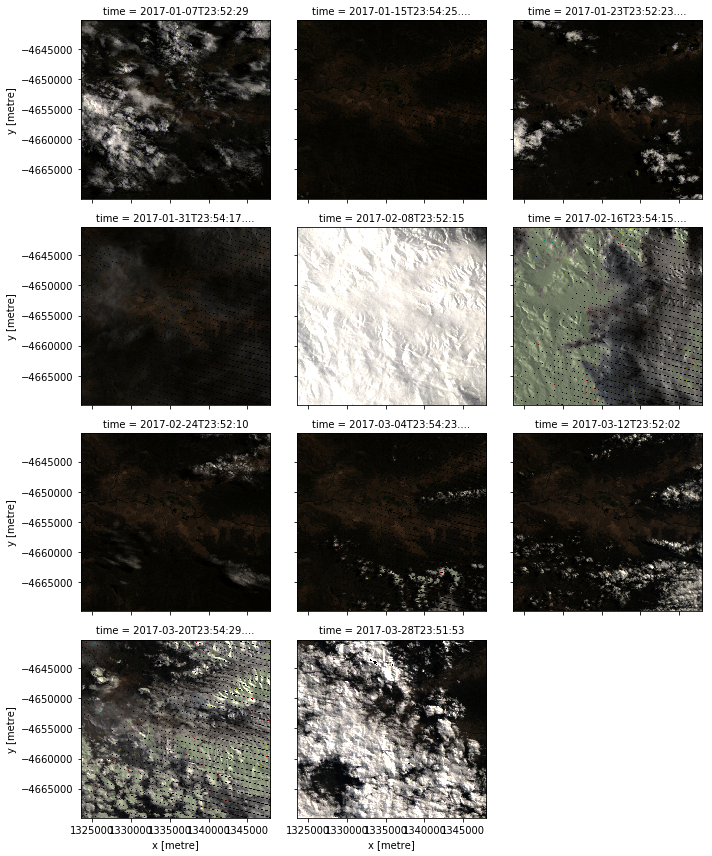

In [23]:
# Plot as RGB image
datasets_combined[['red', 'green', 'blue']].to_array().plot.imshow(col='time', col_wrap=3, robust=True)

In [24]:
# Compute geomedian composite using all timesteps
geomedian_ds = GeoMedian().compute(datasets_combined)

# Plot geomedian layer as RGB image
#datasets_combined[['red', 'green', 'blue']].to_array().plot.imshow(robust=True)

TypeError: No matching signature found

In [ ]:
#datacube.storage.storage.write_dataset_to_netcdf(combined, '/home/554/lm4502/test_multisensor')